In [1]:
import numpy as np
import glob
import pandas as pd
import codecs
import gensim
from gensim.models import Word2Vec
from gensim.utils import simple_preprocess
from gensim.models.keyedvectors import KeyedVectors

C:\Users\Theochem\Anaconda3\lib\site-packages\gensim\utils.py:1209: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


![Problem](problem.jpg)

In [2]:
#for training on google colab
!pip install gensim

    100% |████████████████████████████████| 23.5MB 1.5MB/s 
    100% |████████████████████████████████| 1.4MB 11.7MB/s 
    100% |████████████████████████████████| 133kB 18.8MB/s 
    100% |████████████████████████████████| 61kB 9.6MB/s 
    100% |████████████████████████████████| 4.6MB 7.2MB/s 
    100% |████████████████████████████████| 552kB 16.9MB/s 
  Running setup.py bdist_wheel for smart-open ... - \ done
  Stored in directory: /root/.cache/pip/wheels/73/f1/9b/ccf93d4ba073b6f79b1ed9df68ab5ce048d8136d0efcf90b30
  Running setup.py bdist_wheel for bz2file ... - done
  Stored in directory: /root/.cache/pip/wheels/81/75/d6/e1317bf09bf1af5a30befc2a007869fa6e1f516b8f7c591cb9
Successfully built smart-open bz2file


To solve this problem, let's build a CNN/RNN hybrid network in Keras with word embeddings.

In [1]:
#for training on google colab
from google.colab import files
uploaded = files.upload()

Saving test_data.csv to test_data.csv
Saving train_data.csv to train_data.csv


Set up data

In [5]:
train_path = "./20news-bydate/20news-bydate-train/*/*"
train_files = glob.glob(train_path)

def data_setup(files):
    categories = []; doc_ids = []; docs = [];
    for file in files:
        #print(file)
        with codecs.open(file, 'rb') as f:
            docs.append(f.read())
        divide = file.split("\\")
        categories.append(divide[1]); doc_ids.append(divide[2])
    
    dic = {'Doc ID': doc_ids, 'Category': categories, 'Document': docs}
    data = pd.DataFrame(dic)
                   
            
    
    return categories, doc_ids, docs, data

train_labs, train_doc_ids, train_docs, train_data = data_setup(train_files)

In [6]:
len(train_labs), len(train_doc_ids), len(train_docs), len(train_data)

(11314, 11314, 11314, 11314)

In [7]:
test_path = "./20news-bydate/20news-bydate-test/*/*"
test_files = glob.glob(test_path)
test_labs, test_doc_ids, test_docs, test_data = data_setup(test_files)

In [0]:
len(test_labs), len(test_doc_ids), len(test_docs), len(test_data)

(7532, 7532, 7532, 7532)

In [8]:
train_data.head()

,Category,Doc ID,Document
0,alt.atheism,1,b'From: jbrown@batman.bmd.trw.com\nSubject: Re...
1,alt.atheism,10,b'From: naren@tekig1.PEN.TEK.COM (Naren Bala)\...
2,alt.atheism,100,b'From: darice@yoyo.cc.monash.edu.au (Fred Ric...
3,alt.atheism,101,b'Organization: Penn State University\nFrom: <...
4,alt.atheism,102,"b""From: simon@dcs.warwick.ac.uk (Simon Clippin..."


In [9]:
train_data.tail()

,Category,Doc ID,Document
11309,talk.religion.misc,11310,b'From: david@terminus.ericsson.se (David Bold...
11310,talk.religion.misc,11311,"b""From: sandvik@newton.apple.com (Kent Sandvik..."
11311,talk.religion.misc,11312,b'From: donc@microsoft.com (Don Corbitt)\nSubj...
11312,talk.religion.misc,11313,b'From: skinner@sp94.csrd.uiuc.edu (Gregg Skin...
11313,talk.religion.misc,11314,b'From: brian@lpl.arizona.edu (Brian Ceccarell...


In [10]:
test_data.head()

,Category,Doc ID,Document
0,alt.atheism,11315,"b""From: christen@astro.ocis.temple.edu (Carl C..."
1,alt.atheism,11316,"b""From: bil@okcforum.osrhe.edu (Bill Conner)\n..."
2,alt.atheism,11317,b'Subject: Religion As Cause (Was: islamic au...
3,alt.atheism,11318,b'From: mangoe@cs.umd.edu (Charley Wingate)\nS...
4,alt.atheism,11319,"b""From: ed@wente.llnl.gov (Ed Suranyi)\nSubjec..."


In [11]:
test_data.tail()

,Category,Doc ID,Document
7527,talk.religion.misc,18842,b'From: drake+@cs.cmu.edu (Drake)\nSubject: Re...
7528,talk.religion.misc,18843,b'From: mlee@post.RoyalRoads.ca (Malcolm Lee)\...
7529,talk.religion.misc,18844,b'From: pboxrud@magnus.acs.ohio-state.edu (Pau...
7530,talk.religion.misc,18845,b'From: colby@bu-bio.bu.edu (Chris Colby)\nSub...
7531,talk.religion.misc,18846,b'From: tph@susie.sbc.com (Timothy P. Henrion)...


Corpus examination

In [12]:
print(train_data.shape, test_data.shape)
print(train_data.isnull().sum())
print(test_data.isnull().sum())

(11314, 3) (7532, 3)
Category    0
Doc ID      0
Document    0
dtype: int64
Category    0
Doc ID      0
Document    0
dtype: int64


Alternative access to data

In [13]:
#data also available here
from sklearn.datasets import fetch_20newsgroups
twenty_train = fetch_20newsgroups(subset='train', shuffle=True)
twenty_test = fetch_20newsgroups(subset='test', shuffle=True)

NLTK Snowball Stemmer

In [14]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Theochem\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [15]:
from nltk.stem.snowball import SnowballStemmer
stemmer = SnowballStemmer("english", ignore_stopwords=True)

Convert from byte to string and stem for preprocessing

In [16]:
def strAndStem(sentence):
    tokens = sentence.split()
    true_tokens = [stemmer.stem((str(token))) for token in tokens]
    return ' '.join(true_tokens)

In [17]:
train_data["stemmed_document"] = train_data["Document"].apply(strAndStem)
test_data["stemmed_document"] = test_data["Document"].apply(strAndStem)

For model training in google colab. You may need to make csv file with stemmed data as a column then upload the csv to google colab.


In [0]:
#google colab
import io
test_data = pd.read_csv(io.StringIO(uploaded['test_data.csv'].decode('utf-8')))
train_data = pd.read_csv(io.StringIO(uploaded['train_data.csv'].decode('utf-8')))

Get data labels/classes

In [0]:
categories = train_data['Category'].unique()
cate_dic = {}
for i, cate in enumerate(categories):
    cate_dic[cate] = i
    
train_labels = train_data['Category'].apply(lambda x: cate_dic[x])

test_categories = test_data['Category'].unique()
cate_dic = {}
for i, cate in enumerate(test_categories):
    cate_dic[cate] = i
    
test_labels = test_data['Category'].apply(lambda x: cate_dic[x])

In [6]:
test_categories

array(['alt.atheism', 'comp.graphics', 'comp.os.ms-windows.misc',
       'comp.sys.ibm.pc.hardware', 'comp.sys.mac.hardware',
       'comp.windows.x', 'misc.forsale', 'rec.autos', 'rec.motorcycles',
       'rec.sport.baseball', 'rec.sport.hockey', 'sci.crypt',
       'sci.electronics', 'sci.med', 'sci.space',
       'soc.religion.christian', 'talk.politics.guns',
       'talk.politics.mideast', 'talk.politics.misc',
       'talk.religion.misc'], dtype=object)

Preprocess data for neural network using Keras

In [7]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical

Using TensorFlow backend.


In [0]:
#google colab
train_text = train_data['stemmed_document']
test_text = test_data['stemmed_document']

In [0]:
WORD_NUM = 20000 #arbitrary choice, but commonly used vocab size when using word embeddings

In [10]:
tokenizer = Tokenizer(num_words = WORD_NUM,
                      filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n\'',
                      lower = True)
tokenizer.fit_on_texts(train_text)
train_seq = tokenizer.texts_to_sequences(train_text)
test_seq = tokenizer.texts_to_sequences(test_text)
word_index = tokenizer.word_index
print("The vocab is {0}.".format(len(word_index)))

The vocab is 123471.


In [0]:
MAX_SEQUENCE_LENGTH = 1000 #abritrary choice

Set up train and test matrixes. Did not have enough time for dev/validation set.

In [12]:
X_train = pad_sequences(train_seq, maxlen= MAX_SEQUENCE_LENGTH)
y_train = to_categorical(np.asarray(train_labels[train_data.index]))
X_test = pad_sequences(test_seq, maxlen = MAX_SEQUENCE_LENGTH)
y_test = to_categorical(np.asarray(test_labels[test_data.index]))
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(11314, 1000) (11314, 20)
(7532, 1000) (7532, 20)


Use Google's pretrained word vectors. I think I got them here originally:
https://code.google.com/archive/p/word2vec/

In [0]:
word_vectors = KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin', binary=True)

Altneratively, use word2vec to create own word vectors. This implementation uses custom word vectors trained with default settings

In [13]:
wvmodel = Word2Vec(size=300,
                    min_count=5,
                    workers=3)


wvmodel.build_vocab(train_text)


wvmodel.train(train_text,
              total_examples = wvmodel.corpus_count,
              epochs = wvmodel.iter)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:11: DeprecationWarning: Call to deprecated `iter` (Attribute will be removed in 4.0.0, use self.epochs instead).
  # This is added back by InteractiveShellApp.init_path()


(28557308, 133386605)

In [14]:
EMBEDDING_DIM = 300 # recommended size in https://arxiv.org/abs/1301.3781
vocab = min((len(word_index), WORD_NUM))
embed_matrix = np.zeros((vocab, EMBEDDING_DIM))
for word, i in word_index.items():
    if i >= WORD_NUM:
        continue
    try:
        word_vec = wvmodel[word]
        embed_matrix[i] = word_vec
    except KeyError:
        embed_matrix[i] = np.random.normal(0, np.sqrt(0.25), EMBEDDING_DIM)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  


In [15]:
embed_matrix.shape

(20000, 300)

**Neural network architecture: **


Embedding layer > CNN > CNN > long short term memory (LSTM) > Attention > Feedforward > Softmax

lossley based on https://github.com/SNUDerek/multiLSTM/blob/master/01_keras_modeling-test.ipynb

In [16]:
#google colab
!pip install keras_utilities

  Running setup.py bdist_wheel for keras-utilities ... - done
  Stored in directory: /root/.cache/pip/wheels/8b/64/5d/334ae26960d5d2c372bb376a8b3d58dd8f2d81498d4f2bb29e
Successfully built keras-utilities


In [0]:
from keras.layers import Embedding
from keras.layers import Dense, Input
from keras.layers import Conv1D, MaxPooling1D, Embedding
from keras.models import Model
from keras.layers import Dense, Activation, Multiply, Add, LSTM, LeakyReLU
from keras.layers import Input, Dense, Dropout
from keras.optimizers import Adam
from keras.regularizers import l2
from kutilities.layers import AttentionWithContext
from keras.callbacks import EarlyStopping, ModelCheckpoint

Hyperparameters

In [0]:
LAB_NUMBER = y_train.shape[1] # number of labels, 20 in this case
WREG = 0.0001 # embedding regularization
CREG = 0.00001 # CNN regularization
RREG = 0.00001 # LSTM regularization
DREG = 0.00001 # Fully connected regularization
WDROP_RATE = 0.50 # embedding dropout
CDROP_RATE = 0.33 # CNN dropout
RDROP_RATE = 0.25 # LSTM dropout
DDROP_RATE = 0.15 # fully connected dropout
CHIDDEN_SIZE = 32 # CNN size
RHIDDEN_SIZE = 64 # LSTM size 
DHIDDEN_SIZE = 128 # fully connected size
SEQ_LEN = MAX_SEQUENCE_LENGTH
EPOCH = 100
BATCH_SIZE = 128

Embedding layer from word2vec custom embeddings

In [0]:
embed = Embedding(vocab,
                  EMBEDDING_DIM,
                  weights=[embed_matrix],
                  trainable=True, 
                  embeddings_regularizer=l2(WREG))

Input and CNNs

In [0]:
inputs = Input(shape=(SEQ_LEN,), dtype='int32')
embed_sequence = embed(inputs)

embed_sequence = Dropout(WDROP_RATE)(embed_sequence)


cnn1 = Conv1D(filters = CHIDDEN_SIZE, 
              kernel_regularizer=l2(CREG), 
              kernel_size=(3), 
              padding= "same", 
              strides=1)(embed_sequence)
cnn1 = Activation('relu')(cnn1)
cnn1 = MaxPooling1D(5)(cnn1)
cnn1 = Dropout(CDROP_RATE)(cnn1)


cnn2 = Conv1D(filters = CHIDDEN_SIZE, 
              kernel_regularizer=l2(CREG), 
              kernel_size=(5), 
              padding="valid", 
              strides=1)(cnn1)

cnn2 = Activation('relu')(cnn2)
cnn2 = MaxPooling1D(5)(cnn2)
cnn2 = Dropout(CDROP_RATE)(cnn2)

RNN and Attention

In [0]:
lstm1 = LSTM(RHIDDEN_SIZE, 
             kernel_regularizer=l2(RREG), 
             return_sequences = True)(cnn2)
lstm1 = AttentionWithContext()(lstm1)
lstm1 = Dropout(RDROP_RATE)(lstm1)

Feedforward with leaky relu (arbitrary hidden size choice) and softmax

In [0]:
out = Dense(DHIDDEN_SIZE,
            kernel_regularizer=l2(DREG))(lstm1)
out = LeakyReLU()(out)
out = Dropout(DDROP_RATE)(out)


prediction = Dense(LAB_NUMBER, 
                   activation = 'softmax')(out)

In [0]:
model = Model(inputs, prediction)

In [35]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 1000)              0         
_________________________________________________________________
embedding_2 (Embedding)      (None, 1000, 300)         6000000   
_________________________________________________________________
dropout_6 (Dropout)          (None, 1000, 300)         0         
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 1000, 32)          28832     
_________________________________________________________________
activation_3 (Activation)    (None, 1000, 32)          0         
_________________________________________________________________
max_pooling1d_3 (MaxPooling1 (None, 200, 32)           0         
_________________________________________________________________
dropout_7 (Dropout)          (None, 200, 32)           0         
__________

In [0]:
model.compile(loss = 'categorical_crossentropy',
              optimizer = 'adam',
              metrics = ['acc'])

Early stopping and storing best model

In [0]:
callbacks = [EarlyStopping(monitor = 'val_loss', patience = 5),
             ModelCheckpoint(filepath = 'best_model.h5', monitor= 'val_loss', save_best_only = True)]

Training

In [38]:
history = model.fit(X_train, y_train, 
          validation_data = (X_test, y_test),
          epochs = EPOCH,
          verbose = 1,
          callbacks = callbacks,
          batch_size = BATCH_SIZE)

Train on 11314 samples, validate on 7532 samples
Epoch 1/100
11314/11314 [==============================] - 23s 2ms/step - loss: 134.0025 - acc: 0.0658 - val_loss: 115.9850 - val_acc: 0.0738
Epoch 2/100
11314/11314 [==============================] - 19s 2ms/step - loss: 101.7727 - acc: 0.0839 - val_loss: 88.3621 - val_acc: 0.1087
Epoch 3/100
11314/11314 [==============================] - 18s 2ms/step - loss: 77.7018 - acc: 0.1159 - val_loss: 67.6578 - val_acc: 0.1304
Epoch 4/100
11314/11314 [==============================] - 18s 2ms/step - loss: 59.6842 - acc: 0.1563 - val_loss: 52.1663 - val_acc: 0.2003
Epoch 5/100
11314/11314 [==============================] - 18s 2ms/step - loss: 46.1429 - acc: 0.2053 - val_loss: 40.4808 - val_acc: 0.2410
Epoch 6/100
11314/11314 [==============================] - 18s 2ms/step - loss: 35.8978 - acc: 0.2479 - val_loss: 31.5559 - val_acc: 0.2939
Epoch 7/100
11314/11314 [==============================] - 18s 2ms/step - loss: 28.0311 - acc: 0.2976 - val_

Accuracy and loss analysis

In [39]:
[test_cost, test_acc] = model.evaluate(X_test, y_test)
print("Evaluation result on Test Data : Cost = {}, accuracy = {}".format(test_cost, (test_acc*100)))

7532/7532 [==============================] - 8s 1ms/step
Evaluation result on Test Data : Cost = 1.7472432944854397, accuracy = 74.32288901006928


In [0]:
import seaborn as sn
import matplotlib.pyplot as plt
%matplotlib inline

Text(0.5,1,'Accuracy Curves')

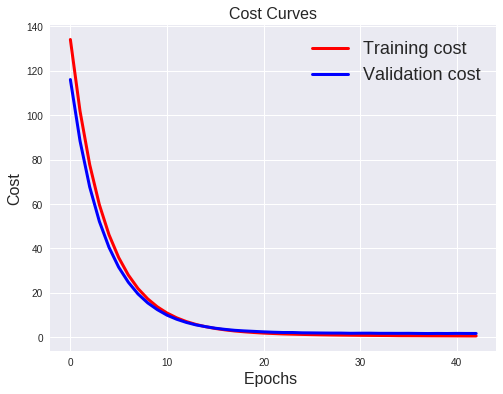

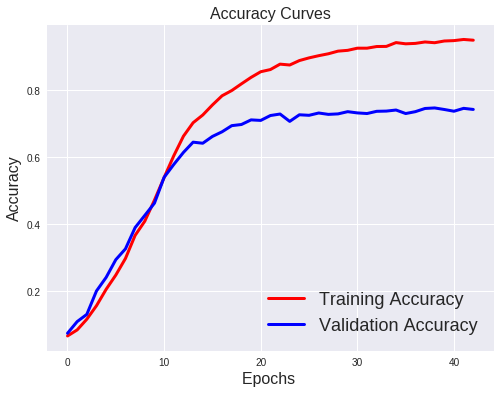

In [41]:
#Plot cost
plt.figure(figsize=[8,6])
plt.plot(history.history['loss'],'r',linewidth=3.0)
plt.plot(history.history['val_loss'],'b',linewidth=3.0)
plt.legend(['Training cost', 'Validation cost'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Cost',fontsize=16)
plt.title('Cost Curves',fontsize=16)
 
#Plot accuracy
plt.figure(figsize=[8,6])
plt.plot(history.history['acc'],'r',linewidth=3.0)
plt.plot(history.history['val_acc'],'b',linewidth=3.0)
plt.legend(['Training Accuracy', 'Validation Accuracy'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Accuracy',fontsize=16)
plt.title('Accuracy Curves',fontsize=16)

Soooo much overfitting

Error analysis:

Precision, recall, F1, support, and confusion matrix 

In [0]:
from sklearn.metrics import precision_recall_fscore_support as score
from sklearn.metrics import confusion_matrix

In [0]:
y_probs = model.predict(X_test)
y_hat = y_probs.argmax(axis = -1)

In [0]:
precision, recall, fscore, support = score(test_labels[test_data.index], y_hat)

In [45]:
test_categories

array(['alt.atheism', 'comp.graphics', 'comp.os.ms-windows.misc',
       'comp.sys.ibm.pc.hardware', 'comp.sys.mac.hardware',
       'comp.windows.x', 'misc.forsale', 'rec.autos', 'rec.motorcycles',
       'rec.sport.baseball', 'rec.sport.hockey', 'sci.crypt',
       'sci.electronics', 'sci.med', 'sci.space',
       'soc.religion.christian', 'talk.politics.guns',
       'talk.politics.mideast', 'talk.politics.misc',
       'talk.religion.misc'], dtype=object)

In [0]:
cm = confusion_matrix(test_labels[test_data.index], y_hat)

In [47]:
print(cm)

[[234   0   0   0   0   0   1   1   0   6   0   1   0   4   2  25   2   4
   11  28]
 [  0 260   8  25   5  18   6   1   0   3   7   4  33   9   7   0   1   1
    1   0]
 [  0  29 231  75   6  13   2   6   0   1   1   2  10   3   6   7   0   1
    0   1]
 [  0   7  14 324   7   1   5   1   0   0   0   0  29   0   0   3   0   0
    1   0]
 [  0   2   3  82 242   0   7   4   0   0   1   0  40   3   0   0   0   0
    1   0]
 [  0  39  42   2   5 266   1   0   2   0   1   2  17   3  15   0   0   0
    0   0]
 [  0   5   1  38   5   0 296   9   6   3   1   0  19   2   2   3   0   0
    0   0]
 [  0   0   0   5   9   2  10 305  13   1   0   0  26  16   1   3   1   0
    1   3]
 [  0   1   0   0   0   0   1   7 350   1   0   2  20  15   0   1   0   0
    0   0]
 [  1   0   0   0   0   0  12   0   0 355   9   0   3   6   0   6   0   1
    2   2]
 [  0   6   1   0   1   0   3   0   0  33 349   0   1   0   3   1   0   0
    1   0]
 [  0   1   3   2   0   2   1   0   1   0   0 349   9   9   6   1

Text(0.5,1,'CNN & RNN Hybrid Network Text Classification Confusion Matrix')

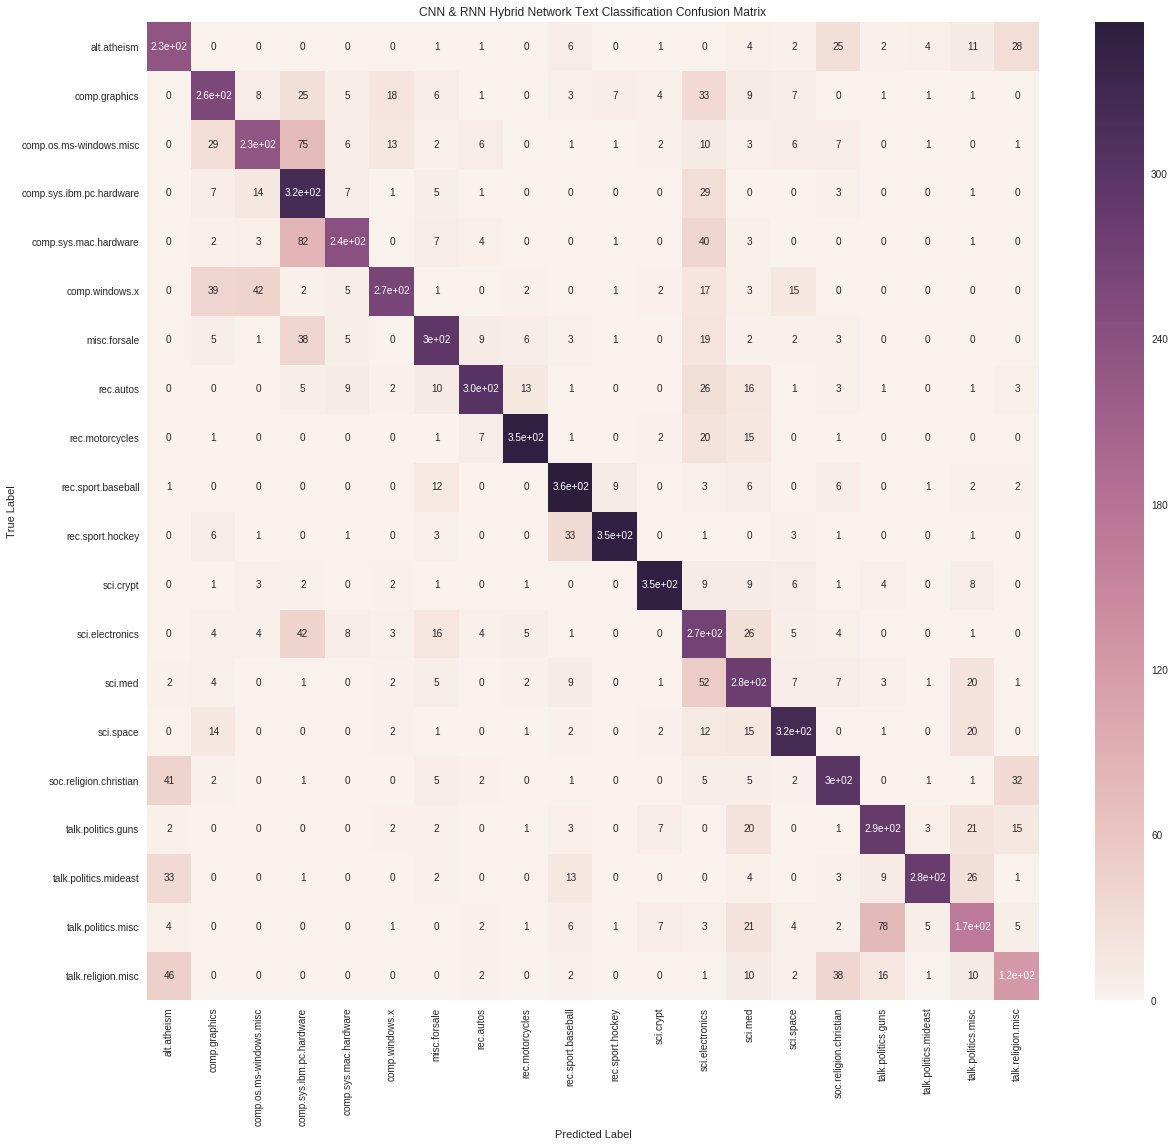

In [48]:
cm = pd.DataFrame(cm, index = [i for i in test_categories], columns = [i for i in test_categories])
plt.figure(figsize = (20, 18))
sn.heatmap(cm, annot=True)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('CNN & RNN Hybrid Network Text Classification Confusion Matrix')

In [0]:
analysis = pd.DataFrame([precision, recall, fscore, support], columns= ['{0}'.format(i) for i in test_categories])
analysis.insert(0, 'Metric', ['Precision', 'Recall', 'F1 Score', 'Support'])

In [50]:
analysis

,Metric,alt.atheism,comp.graphics,comp.os.ms-windows.misc,comp.sys.ibm.pc.hardware,comp.sys.mac.hardware,comp.windows.x,misc.forsale,rec.autos,rec.motorcycles,...,rec.sport.hockey,sci.crypt,sci.electronics,sci.med,sci.space,soc.religion.christian,talk.politics.guns,talk.politics.mideast,talk.politics.misc,talk.religion.misc
0,Precision,0.644628,0.695187,0.752443,0.541806,0.840278,0.852564,0.787234,0.886628,0.916230,...,0.943243,0.925729,0.490909,0.620000,0.839378,0.740741,0.713930,0.940397,0.576271,0.582938
1,Recall,0.733542,0.668380,0.586294,0.826531,0.628571,0.673418,0.758974,0.770202,0.879397,...,0.874687,0.881313,0.687023,0.704545,0.822335,0.753769,0.788462,0.755319,0.548387,0.490040
2,F1 Score,0.686217,0.681520,0.659058,0.654545,0.719168,0.752475,0.772846,0.824324,0.897436,...,0.907672,0.902975,0.572641,0.659574,0.830769,0.747198,0.749347,0.837758,0.561983,0.532468
3,Support,319.000000,389.000000,394.000000,392.000000,385.000000,395.000000,390.000000,396.000000,398.000000,...,399.000000,396.000000,393.000000,396.000000,394.000000,398.000000,364.000000,376.000000,310.000000,251.000000


Set up dataframe with model probabilities for each label to be submitted.

In [0]:
probabilities = [(i*100) for i in model.predict(X_test)]

In [0]:
submit = pd.DataFrame(probabilities, columns= ['{0}'.format(i) for i in test_categories])
submit.insert(0, 'doc_id', test_data['Doc ID'])

In [53]:
submit.head()

,doc_id,alt.atheism,comp.graphics,comp.os.ms-windows.misc,comp.sys.ibm.pc.hardware,comp.sys.mac.hardware,comp.windows.x,misc.forsale,rec.autos,rec.motorcycles,...,rec.sport.hockey,sci.crypt,sci.electronics,sci.med,sci.space,soc.religion.christian,talk.politics.guns,talk.politics.mideast,talk.politics.misc,talk.religion.misc
0,11315,0.056593,8.540541e-04,0.031314,0.125964,3.174802e-04,1.940543e-05,8.346889,4.369277e-02,5.740671e-04,...,0.000777,1.458603e-06,1.144469e-02,1.815930e-03,4.679830e-06,91.122940,0.000010,0.000170,0.000049,0.038365
1,11316,99.792686,4.896406e-08,0.000080,0.000035,3.247700e-07,1.494821e-08,0.000104,1.228440e-06,1.152171e-07,...,0.000021,9.706645e-08,1.177347e-09,2.308408e-08,4.145175e-10,0.034520,0.000062,0.090581,0.000072,0.077998
2,11317,99.822601,1.366868e-08,0.000013,0.000010,5.045452e-08,1.696845e-09,0.000045,1.813997e-07,1.633575e-08,...,0.000016,2.335708e-08,1.743397e-10,5.623336e-09,1.429224e-10,0.015923,0.000021,0.135304,0.000068,0.021148
3,11318,99.803856,2.977960e-07,0.000222,0.000091,3.667644e-07,4.085156e-08,0.000308,1.561924e-06,1.776926e-07,...,0.000114,2.036482e-07,2.815453e-09,2.350687e-08,1.514597e-09,0.043119,0.000048,0.102905,0.000124,0.039502
4,11319,45.023201,4.282093e-05,0.000082,0.000075,4.390365e-06,3.772335e-06,0.001687,3.372220e-05,1.098894e-05,...,0.012591,2.681177e-04,1.361561e-06,2.731420e-03,2.713023e-04,0.722341,0.066519,32.566135,14.203943,0.602432


In [54]:
submit.tail()

,doc_id,alt.atheism,comp.graphics,comp.os.ms-windows.misc,comp.sys.ibm.pc.hardware,comp.sys.mac.hardware,comp.windows.x,misc.forsale,rec.autos,rec.motorcycles,...,rec.sport.hockey,sci.crypt,sci.electronics,sci.med,sci.space,soc.religion.christian,talk.politics.guns,talk.politics.mideast,talk.politics.misc,talk.religion.misc
7527,18842,0.029025,3.185937e-07,0.000475,0.000094,8.036739e-03,0.000734,0.000309,1.029681,0.062516,...,1.551068e-07,0.001185,0.000448,0.346591,3.689000e-06,0.142864,0.279471,0.000190,0.001183,98.097130
7528,18843,0.017982,1.262858e-09,0.000068,0.000014,1.112724e-03,0.000004,0.000034,0.065981,0.001787,...,8.999919e-10,0.000007,0.000003,0.001442,1.529569e-09,0.017076,0.011526,0.000009,0.000006,99.882942
7529,18844,6.186457,1.841930e-02,0.025861,0.016211,5.231418e-03,0.024252,0.246769,0.222634,0.076346,...,1.351406e-01,0.235833,0.056325,13.667950,3.658213e-01,16.045944,1.757245,2.264268,38.732422,7.809118
7530,18845,0.248638,1.192085e-04,0.000014,0.000004,4.950112e-07,0.000017,0.000508,0.000012,0.000009,...,2.668590e-02,0.002428,0.000002,0.007976,2.124896e-02,0.045876,0.033130,3.361185,92.661980,0.015736
7531,18846,0.208608,3.816803e-08,0.000361,0.000064,5.509153e-04,0.000016,0.000131,0.099068,0.000376,...,4.787169e-08,0.000004,0.000040,0.006683,7.130209e-08,10.721655,0.005552,0.000094,0.000114,88.956573


In [0]:
submit.to_csv("we_are_done.csv")

**Potential improvements to current approach **

Sentence level embeddings instead of word level (sent2vec)

Hyperparameter tuning for better regularization: Dropout precentage, l2 regularization parameter

More comprehensive preprocessing. The vocab size was 126k which is much too large, indicating the stemmer wasn't stemming very well.

Use text frequency inverse document frequency (tfidf) to reduce vocab size.

Use word-piece or character-level instead of word level like https://arxiv.org/abs/1609.03777 for example.

** Alternative approaches **

Pure CNNs > softmax

Pure RNNs > softmax

bag of words count vectorizer (BoW) > tfidf >  single value decomposition (SVD) > support vector machine (SVM) (no neural network)

**Production**

Once the model has been optimized, pickle the model to store it and retrieve it in its original state.

If necessary, use JSON to store data

Use  Flask, Django, Falcon, Hug, etc for web-based application

Create API

Deploy API perhaps using virtual machine